# Experiments

In [1]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import dill
import tqdm

from pcg_stein.distribution import BayesianLogisticRegression
from pcg_stein.kernel import Matern52Kernel, Matern72Kernel, IMQKernel, GaussianKernel
from pcg_stein.pcg import pcg
from pcg_stein.precon import Nystrom, NystromDiagonal, NystromRandom, RandomisedSVD, FITC, BlockJacobi
from pcg_stein.util import PCG_Experiment

jax.config.update("jax_enable_x64", True) # double precision


In [2]:
kernel = Matern52Kernel()


# dist = BayesianLogisticRegression.from_synthetic(jax.random.key(0), 1000, true_beta=jnp.array([1., -1, 2, 4]))
# X = dist.sample(jax.random.key(1), 5)
# Sx = dist.score(X)


In [3]:
from pcg_stein.pcg import pcg, pcg_batch

In [4]:
X = jax.random.normal(jax.random.key(0), (100, 7))
Sx = -X

K = kernel.stein_matrix(X, X, Sx, Sx, lengthscale=1.)

In [5]:
precon = BlockJacobi()

precon_mats = [precon(None, K, block_size=i + 1) for i in range(3)]
precon_batch = jnp.stack(precon_mats)


In [14]:
pcg_batch(K, jnp.ones(100), precon_batch)[-1]

Array([0.4309011, 0.4309011, 0.4309011], dtype=float64)

In [15]:
pcg(K, jnp.ones(100), M_inv=precon_batch[0], return_history=False)

(Array([0.05025452, 0.0485326 , 0.08813574, 0.05650098, 0.04502066,
        0.04143131, 0.05833093, 0.03981602, 0.05556404, 0.04251923,
        0.0476227 , 0.03769065, 0.04534264, 0.06402057, 0.04630251,
        0.09201863, 0.05836723, 0.04671601, 0.04259995, 0.05120191,
        0.07921967, 0.03024542, 0.04780749, 0.05507771, 0.05884192,
        0.06136157, 0.04225565, 0.06605393, 0.03949813, 0.05528566,
        0.03684743, 0.04672696, 0.06064522, 0.06900349, 0.04690839,
        0.07606371, 0.03908475, 0.05509464, 0.0408857 , 0.03934513,
        0.07837764, 0.04594796, 0.07927124, 0.04885628, 0.06882295,
        0.03877238, 0.04079298, 0.07620579, 0.08330991, 0.05384777,
        0.04918004, 0.04997758, 0.05235846, 0.06310649, 0.04190933,
        0.08517859, 0.04235304, 0.08984197, 0.05613335, 0.05968467,
        0.07672905, 0.06163324, 0.05397656, 0.05847739, 0.0570536 ,
        0.04398306, 0.04917366, 0.05997381, 0.05262601, 0.05084137,
        0.04935035, 0.04459715, 0.03830811, 0.04

In [11]:
precon.old_call(None, K, block_size=7)

Array([[5.80962348e-02, 1.12166611e-04, 4.38744951e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.12166611e-04, 4.43278369e-02, 2.01275921e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.38744951e-04, 2.01275921e-04, 6.87991681e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.33725676e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.77350528e-02, 3.39975892e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.39975892e-05, 4.94699519e-02]], dtype=float64)

In [8]:
b = jnp.ones(5)

print(kernel.stein_matvec(b, X, Sx))

[1100.29861908 1847.94647142 1744.80253063 2273.06705475 2012.30810783]


In [ ]:
cfg_path = os.path.join("experiments", "fig1_experiment", "experiment.yaml")


In [2]:
import os
import yaml

from pcg_stein.registry import PRECON_REGISTRY, KERNEL_REGISTRY, DISTRIBUTION_REGISTRY

# Construct the full path to your config file
cfg_path = os.path.join("experiments", "fig1_experiment", "experiment.yaml")

# Load the YAML config
with open(cfg_path, "r") as f:
    exp_cfg = yaml.safe_load(f)

# Static parameters
REPLICATES           = exp_cfg["replicates"]
WCE_MUL              = exp_cfg["wce_mul"]
N_ITER_WCE_REFERENCE = exp_cfg["n_iter_wce_reference"]
MAXITER              = exp_cfg["maxiter"]
NUM_MCMC_SAMPLES     = exp_cfg["num_mcmc_samples"]
NUM_SYNTH            = exp_cfg["num_synth_samps"]
M_RANK               = exp_cfg["m_rank"]
DIST_CLS             = DISTRIBUTION_REGISTRY[exp_cfg["dist"]]
KERNEL_CLS           = KERNEL_REGISTRY[exp_cfg["kernel"]]
PRECON_NAMES         = exp_cfg["precons"]
BLOCK_SIZES          = list(map(int, exp_cfg["block_sizes"])) # cast strings correctly just in case
NUGGETS              = list(map(float, exp_cfg["nuggets"]))
LENGTHSCALES         = list(map(float, exp_cfg["lengthscales"]))  
TRUE_BETA            = jnp.array(list(map(float, exp_cfg["true_beta"])))

# define distribution once:
dist = DIST_CLS.from_synthetic(jax.random.PRNGKey(exp_cfg["dist_synth_key"]),
                                NUM_SYNTH, true_beta=TRUE_BETA)

jobs = []
for rep in range(REPLICATES):
    for ls in LENGTHSCALES:
        for name in PRECON_NAMES:
            pc_cls = PRECON_REGISTRY[name]
            if name == "BlockJacobi":
                for bs in BLOCK_SIZES:
                    jobs.append({
                        "replicate":    rep,
                        "lengthscale":  ls,
                        "precon_cls":   pc_cls,
                        "precon_kwargs":{"block_size": bs, "m":M_RANK},
                    })
            else:
                for ng in NUGGETS:
                    jobs.append({
                        "replicate":    rep,
                        "lengthscale":  ls,
                        "precon_cls":   pc_cls,
                        "precon_kwargs":{"nugget": ng, "m":M_RANK},
                    })


In [1]:
def run_one(
    replicate:    int,
    lengthscale:  float,
    precon_cls,         
    precon_kwargs: dict,
    *, 
    rngs,                # dict of PRNG keys
) -> dict:
    """
    Runs a single PCG-vs-CG job.

    Args:
        replicate      : Which replicate index this is.
        lengthscale    : Kernel lengthscale.
        precon_cls     : Preconditioner class to instantiate.
        precon_kwargs  : Keyword args for that preconditioner.
        rngs           : dict with keys 'data', 'precon'.

    Returns:
        A dict of scalar results, e.g. k_iters, final_res, final_wce, plus metadata.
    """
    # 1. sample MCMC data and compute scores
    mcmc_key, precon_key = rngs["data"], rngs["precon"]
    X = dist.sample(mcmc_key, NUM_MCMC_SAMPLES) # MCMC samples
    Sx = dist.score(X) # Scores

    # 2. build PCG experiment object
    kernel = KERNEL_CLS()

    # 3. Define linear system and preconditioner
    kernel_kwargs = {'lengthscale': lengthscale}
    K = kernel.stein_matrix(X, X, Sx, Sx, **kernel_kwargs) # K in Kx = b
    b = jnp.ones(NUM_MCMC_SAMPLES) # b in Kx = b
    precon_mat = precon_cls()(precon_key, K, **precon_kwargs) # preconditioner matrix

    # 4. Compute reference worst-case error and tolerance
    _, _, _, errs = pcg(K, b, maxiter=N_ITER_WCE_REFERENCE, rtol=0., atol=0., wce_tol=0.)
    wce = errs[-1]
    wce_tol = wce * WCE_MUL

    # 5. run CG for baseline
    cg_out = pcg(K, b, rtol=0., atol=0., wce_tol=wce_tol, maxiter=MAXITER)
    m_cg = cg_out[1]

    # 5. run PCG with the chosen preconditioner
    pcg_out = pcg(K, b, rtol=0., atol=0., wce_tol=wce_tol, maxiter=MAXITER, M_inv=precon_mat)
    m_pcg = pcg_out[1]

    # 6. Evaluation metrics
    gain = jnp.log(m_cg + 1) - jnp.log(m_pcg + 1)
    diff = m_cg - m_pcg
    
    return {
        "replicate":    replicate,
        "precon":       precon_cls.name,
        "lengthscale":  lengthscale,
        **precon_kwargs,
        "m_cg":         m_cg,
        "m_pcg":        m_pcg,
        "gain":      gain,
        "diff": diff
    }



# from tqdm.auto import tqdm
# import jax

# # prime a top‐level key
# key = jax.random.PRNGKey(0)

# rows = []
# for job in tqdm(jobs):
#     # split out three RNGs for data / precon / pcg
#     key, data_key, precon_key = jax.random.split(key, 3)
#     rngs = {"data": data_key, "precon": precon_key}

#     # unpack the job dict directly into run_one
#     row = run_one(**job, rngs=rngs)
#     rows.append(row)

# # build a DataFrame and save
# import pandas as pd
# df = pd.DataFrame(rows)
# # df.to_csv("results/fig1.csv", index=False)


In [10]:
job['precon_cls']

pcg_stein.precon.Nystrom

In [15]:
job['precon_kwargs']

{'nugget': '1e-4', 'm': 50}

In [13]:
test = job['precon_cls']()

testkey = jax.random.key(1)
mcmc_key, precon_key = jax.random.split(testkey, 2)
X = dist.sample(mcmc_key, NUM_MCMC_SAMPLES) # MCMC samples
Sx = dist.score(X) # Scores

# 2. build PCG experiment object
kernel = KERNEL_CLS()

# 3. Define linear system and preconditioner
kernel_kwargs = {'lengthscale': job['lengthscale']}
K = kernel.stein_matrix(X, X, Sx, Sx, **kernel_kwargs) # K in Kx = b
b = jnp.ones(NUM_MCMC_SAMPLES) # b in Kx = b
# precon_mat = precon_cls()(precon_key, K, **precon_kwargs) # preconditioner matrix

In [18]:
job['precon_kwargs']

{'nugget': '1e-4', 'm': 50}

In [ ]:
precon_mat = test(precon_key, K, m=50, nugget=1e-4) #works

precon_mat = test(precon_key, K, **job['precon_kwargs']) # does not!

    def __call__(self, key: Array, matrix: Array, **kwargs) -> Array:
        r"""
        Construct the Nystrom preconditioner using the Woodbury Inverse.

        Args:
            key: Array
                JAX random key for sampling indices, if not provided.
            matrix: Array
                Input matrix (shape: [n, n]).
            m: int, required.
                Number of columns/rows for Nystrom approximation.
            max_cond_number: float, optional
                Maximum allowed condition number for pseudoinverse (default 1e14).
            indices: array or None, optional.
                Explicit indices for Nystrom subset.
            nugget: float, required.
                Diagonal regulariser in Woodbury inverse.

        Returns:
            precon: (n, n) matrix.
                Approximation to (K + nugget * I)^{-1} using the Nystrom-Woodbury formula.
        """
        # ---------- kwargs & sanity checks -----------------------------
        m = kwargs.get("m")
        nugget = kwargs.get("nugget")
        max_cond_number = kwargs.get("max_cond_number", 1e14)
        indices = kwargs.get("indices", None)




In [19]:
job['precon_kwargs']

{'nugget': '1e-4', 'm': 50}

In [22]:
test(precon_key, K, **job['precon_kwargs'])

TypeError: Only integer scalar arrays can be converted to a scalar index.

In [17]:
precon_mat = test(precon_key, K, m=50, nugget=1e-4)

In [8]:
job_index = 0
job = jobs[job_index]

key = jax.random.key(0)
key, data_key, precon_key = jax.random.split(key, 3)
rngs = {"data": data_key, "precon": precon_key}

run_one(**job, rngs=rngs)


TypeError: Only integer scalar arrays can be converted to a scalar index.

In [ ]:
class PCG_Experiment:

    def __init__(
        self,
        dist: Distribution,
        dist_sample: Array,
        kernel: Kernel,
        preconditioners: list[Preconditioner],
    ):
        """
        Initialises the PCG experiment with the target distribution, sample data, kernel, and preconditioners.

        Args:
            dist (Distribution): The target distribution defining the log density and score function.
            dist_sample (Array): A set of samples drawn from the target distribution.
            kernel (Kernel): A positive-definite kernel function used to construct the Stein kernel matrix.
            preconditioners (list[Preconditioner]): A list of preconditioners to be applied.
        """

        self.dist = dist  # posterior
        self.X = dist_sample  # posterior samples
        self.Sx = self.dist.score(self.X)  # posterior scores

        self.n, self.d = self.X.shape

        self.kernel = kernel
        self.preconditioners = preconditioners

        self.wce = None

    def _stein_matrix(self, **kernel_kwargs: Any):
        return self.kernel.stein_matrix(
            self.X, self.X, self.Sx, self.Sx, **kernel_kwargs
        )

    def set_reference_wce(
        self, wce: Optional[float] = None, maxiter: int = 10_000, **hyper: Any
    ):
        """
        Sets reference worst-case error to be used as termination criterion in PCG for the experiment.
        """
        if wce is None:
            stein_matrix = self._stein_matrix(**hyper)
            _, _, _, errs = pcg(
                stein_matrix, b=jnp.ones(self.n), maxiter=maxiter, rtol=0.0, atol=0.0
            )
            self.wce = errs[-1]
        else:
            self.wce = wce

    def __call__(
        self,
        precon_key: Array,
        *,
        wce_mul: float = 1.1,
        maxiter: int = 1_000,
        kernel_kwargs: dict | None = None,
        precon_kwargs: dict | None = None,
        debug_mode: bool = True,
    ):
        """
        Runs a PCG experiment. Compares the close

        Args:
            precon_key: Array
                Used in random preconditioners.
            wce_mul: float
                The number multiplied by the reference worst-case error to act as termination criterion.
            max_iter: int, optional
                Maximum number of iterations of PCG to perform before failure
            kernel_kwargs  : dict, optional
                Extra args forwarded only to kernel.stein_matrix().
            precon_kwargs  : dict, optional
                Extra args forwarded only to each preconditioner.
        Returns:
            A dictionary of gains for each preconditioner. The gain is defined as log(1 + m_CG) - log(1 + m_PCG),
            where m_CG/m_PCG are the number of iterations of CG/PCG required for
            the the worst-case error termination criterion to be fulfilled.
        """

        debug_output = []

        kernel_kwargs = {} if kernel_kwargs is None else kernel_kwargs
        precon_kwargs = {} if precon_kwargs is None else precon_kwargs

        stein_matrix = self._stein_matrix(**kernel_kwargs)

        # compute reference worst-case error if required:
        if self.wce is None:
            self.set_reference_wce(**kernel_kwargs)

        wce_tol = (
            wce_mul * self.wce
        )  # worst-case error tolerance (termination criterion in PCG)

        # define b in Mx = b
        b = jnp.ones(self.n)

        # run CG without preconditioner
        cg_output = pcg(
            stein_matrix, b=b, maxiter=maxiter, rtol=0.0, atol=0.0, wce_tol=wce_tol
        )

        m_cg = cg_output[1]

        if debug_mode is True:
            debug_dict = self.check_failure_conditions(
                cg_output,
                precon=None,
                precon_mat=None,
                maxiter=maxiter,
                wce_tol=wce_tol,
                kernel_kwargs=kernel_kwargs,
                precon_kwargs=None,
            )
            if debug_dict is not None:
                debug_output.append(debug_dict)

        gain_dict = {}

        # run PCG for each preconditioner
        for precon in self.preconditioners:
            precon_key, _ = jax.random.split(precon_key, 2)
            precon_mat = precon(precon_key, stein_matrix, **precon_kwargs)

            pcg_output = pcg(
                stein_matrix,
                b=b,
                maxiter=maxiter,
                rtol=0.0,
                atol=0.0,
                wce_tol=wce_tol,
                M_inv=precon_mat,
            )

            m_pcg = pcg_output[1]
            gain = jnp.log(1 + m_cg) - jnp.log(1 + m_pcg)
            gain_dict[precon.name] = gain

            if debug_mode is True:
                debug_dict = self.check_failure_conditions(
                    pcg_output,
                    precon=precon,
                    precon_mat=precon_mat,
                    maxiter=maxiter,
                    wce_tol=wce_tol,
                    kernel_kwargs=kernel_kwargs,
                    precon_kwargs=precon_kwargs,
                )
                if debug_dict is not None:
                    debug_output.append(debug_dict)

        return gain_dict

    def check_failure_conditions(
        self,
        pcg_output: tuple[Array, ...],
        precon: Optional[Preconditioner] = None,
        precon_mat: Optional[Array] = None,
        precon_key: Optional[Array] = None,
        maxiter: int = 1_000,
        wce_tol: Optional[float] = 0.0,
        kernel_kwargs: dict | None = None,
        precon_kwargs: dict | None = None,
    ):

        x, k, res, wce = pcg_output

        nan_check = jnp.any(jnp.isnan(x))
        termination_check = bool(k == maxiter)

        if precon is None:
            name = "CG"
        else:
            name = precon.name

        if nan_check:
            print(f"nan check failed for {name}")
        if termination_check:
            print(f"Termination check failed for {name} (maxiter {maxiter} met)")

        fail_bool = nan_check or termination_check

        if fail_bool:
            debug_dict = {
                "pcg_output": pcg_output,
                "precon_mat": precon_mat,
                "precon_key": precon_key,
                "kernel_kwargs": kernel_kwargs,
                "precon_kwargs": precon_kwargs,
                "wce_tol": wce_tol,
            }
            return debug_dict
        else:
            return None

In [ ]:
from pcg_stein.registry import PRECON_REGISTRY, KERNEL_REGISTRY, DISTRIBUTION_REGISTRY

def run_one(cfg, *, rngs) -> dict:
    """
    Runs one experiment with
    Args:

        rngs : dict of JAX PRNG keys with dict keys 'data', 'precon', 'pcg'
 
    """

    kernel = KERNEL_REGISTRY[cfg.kernel]
    precon = PRECON_REGISTRY[cfg.precon]

    lengthscale = cfg.lengthscale
    
    


In [4]:
from pcg_stein.registry import KERNEL_REGISTRY, PRECON_REGISTRY

KERNEL_REGISTRY

{'Matern52': pcg_stein.kernel.Matern52Kernel,
 'Matern72': pcg_stein.kernel.Matern72Kernel,
 'Gaussian': pcg_stein.kernel.GaussianKernel,
 'IMQ': pcg_stein.kernel.IMQKernel}

In [5]:
PRECON_REGISTRY

{'Nystrom': pcg_stein.precon.Nystrom,
 'NystromRandom': pcg_stein.precon.NystromRandom,
 'NystromDiagonal': pcg_stein.precon.NystromDiagonal,
 'RandomisedSVD': pcg_stein.precon.RandomisedSVD,
 'FITC': pcg_stein.precon.FITC,
 'BlockJacobi': pcg_stein.precon.BlockJacobi}

In [ ]:
kernel = Matern52Kernel()
precons = [Nystrom(), NystromDiagonal(), NystromRandom(), RandomisedSVD(), FITC(), BlockJacobi()]

synth_data_key = jax.random.key(0) # key used to generate synthetic data
n_synth_data = 1_000
true_beta = jnp.array([1.0, -2.0, 1.0, 4.0])
dist = BayesianLogisticRegression.from_synthetic(synth_data_key, n_synth_data, true_beta=true_beta)
X = dist.sample(jax.random.key(0), 1000)
Sx = dist.score(X)

stein_mat = kernel.stein_matrix(X, X, Sx, Sx)
b = jnp.ones(1000)

key = jax.random.key(1)
precons[0](key, stein_mat, nugget=1e-3, block_size=5, m=50).shape

(1000, 1000)

In [ ]:
key = jax.random.key(1)

pcg_exp = PCG_Experiment(dist, X, kernel, precons)



pcg_exp(key, precon_kwargs={'m': 50, 'nugget':1e-1, 'block_size': 5}, kernel_kwargs={'lengthscale': 1e-1})

{'Nystrom': Array(0., dtype=float64, weak_type=True),
 'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
 'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
 'Randomised SVD': Array(0.28768207, dtype=float64, weak_type=True),
 'FITC': Array(0., dtype=float64, weak_type=True),
 'Block Jacobi': Array(0., dtype=float64, weak_type=True)}

In [77]:
ell = 1.
stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale=ell)
pcg_exp.set_reference_wce(lengthscale=ell)
wce = pcg_exp.wce
print(wce)

out_cg = pcg(stein_mat, b, wce_tol = wce * 1.01, atol=0., rtol=0., M_inv=None)

m_inv = precons[2](jax.random.key(1), stein_mat, nugget=1e-1, block_size=5, m=50)

out_pcg = pcg(stein_mat, b, wce_tol = wce * 1.01, atol=0., rtol=0., M_inv=m_inv)

print('cg iters:', out_cg[1])
print('pcg iters:' ,out_pcg[1])

0.018074998514670412
cg iters: 458
pcg iters: 65


In [78]:
out_cg = pcg(stein_mat, b, maxiter=1000, wce_tol=0., atol=0., rtol=0., M_inv=None)
out_pcg = pcg(stein_mat, b, maxiter=1000, wce_tol=0., atol=0., rtol=0., M_inv=m_inv)

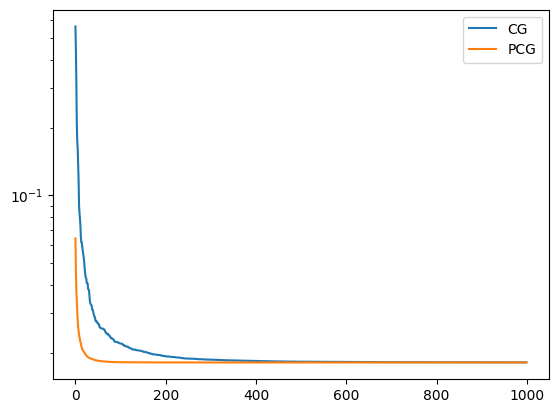

In [79]:
plt.plot(out_cg[3], label='CG')
plt.plot(out_pcg[3], label='PCG')
plt.yscale('log')
plt.legend()

In [53]:
out_pcg[1]

Array(28, dtype=int64, weak_type=True)

In [ ]:
pcg(stein_mat, b, wce_tol=0.74676366 * 1.1, M_inv=None)

In [31]:
pcg_exp.set_reference_wce(lengthscale=lengthscales[0])

In [32]:
pcg_exp.wce

Array(1.66237682, dtype=float64)

In [7]:
pcg_exp.wce

Array(0.74676366, dtype=float64)

In [29]:
lengthscales[0]

Array(0.04978707, dtype=float64)

In [33]:
X = dist.sample(jax.random.key(0), 1000)
Sx = dist.score(X)

stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale=lengthscales[0])

b = jnp.ones(1000)
pcg(stein_mat, b, wce_tol=1.66237682 * 1.1, M_inv=None)

(Array([0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00033056, 0.00033056,
        0.00033056, 0.00033056, 0.00033056, 0.00

In [11]:
m_inv = precons[0](jax.random.key(1), stein_mat, nugget=1e-1, m=50)

pcg(stein_mat, b, wce_tol=0.74676366 * 1.1, M_inv=m_inv)[3]

Array([0.05920149], dtype=float64)

In [34]:
stein_mat = kernel.stein_matrix(X, X, Sx, Sx, lengthscale = lengthscales[0])
out = pcg(stein_mat, b, wce_tol=0., maxiter=10000, M_inv=None, rtol=0., atol=0.)

In [36]:
out[3]

Array([1.73930032, 1.67140446, 1.66377101, ..., 1.66237682, 1.66237682,
       1.66237682], dtype=float64)

In [ ]:
kernel = Matern52Kernel()
precons = [Nystrom(), NystromDiagonal(), NystromRandom(), RandomisedSVD(), FITC(), BlockJacobi()]

synth_data_key = jax.random.key(0) # key used to generate synthetic data
n_synth_data = 1_000
true_beta = jnp.array([1.0, -2.0, 1.0, 4.0])
dist = BayesianLogisticRegression.from_synthetic(synth_data_key, n_synth_data, true_beta=true_beta)

# Define preconditioner parameters
block_sizes = [1] # block sizes to use in BlockJacobi
nuggets = jnp.logspace(-4, 4, 1, base=10) # Woodbury inverse nuggets - could use jnp.logspace(-4, 4, 4)
m = 50 # target rank of approximation

# Define kernel parameters
lengthscales = jnp.logspace(-3, 1, 1, base=jnp.e)

# Define Experiment Variables
num_replicates = 2 # number of repeated experiments 
n = 1_000 # number of MCMC samples to be generated
keys = [jax.random.key(1), jax.random.key(2)] # [key for MCMC sampling, key for preconditioner]

def run_experiments(kernel, precons, keys, block_sizes, nuggets, lengthscales, m=m, num_replicates=num_replicates, n=n, wce_mul=1.01):
    assert len(block_sizes) == len(nuggets)
    
    sample_key, precon_key = keys

    results = []

    for r in range(num_replicates):
        sample_key, _ = jax.random.split(sample_key, 2)
        dist_sample_r = dist.sample(sample_key, n)
        for i in range(len(lengthscales)):
            kernel_kwargs = {'lengthscale': lengthscales[i]}
            pcg_experiment = PCG_Experiment(dist, dist_sample_r, kernel, precons)
            pcg_experiment.set_reference_wce(**kernel_kwargs)

            for j in range(len(block_sizes)):
                precon_kwargs = {'block_size': block_sizes[i], 'nugget': nuggets[i], 'm': m}
                experiment_out = pcg_experiment(precon_key, wce_mul=wce_mul, kernel_kwargs=kernel_kwargs, precon_kwargs=precon_kwargs)
                result = {'out': experiment_out, 'kernel_kwargs':kernel_kwargs, 'precon_kwargs': precon_kwargs}
                results.append(result)
    
    return results


run_experiments(kernel, precons, keys, block_sizes, nuggets, lengthscales, m=m, num_replicates=2, n=n, wce_mul=1.1)





[{'out': {'Nystrom': Array(0., dtype=float64, weak_type=True),
   'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
   'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
   'Randomised SVD': Array(0., dtype=float64, weak_type=True),
   'FITC': Array(0., dtype=float64, weak_type=True),
   'Block Jacobi': Array(0., dtype=float64, weak_type=True)},
  'kernel_kwargs': {'lengthscale': Array(0.04978707, dtype=float64)},
  'precon_kwargs': {'block_size': 1,
   'nugget': Array(1.e-04, dtype=float64),
   'm': 50}},
 {'out': {'Nystrom': Array(0., dtype=float64, weak_type=True),
   'Nystrom (diagonal sampling)': Array(0., dtype=float64, weak_type=True),
   'Nystrom (random projection)': Array(0., dtype=float64, weak_type=True),
   'Randomised SVD': Array(0., dtype=float64, weak_type=True),
   'FITC': Array(0., dtype=float64, weak_type=True),
   'Block Jacobi': Array(0., dtype=float64, weak_type=True)},
  'kernel_kwargs': {'lengthscale': Array(0.0497870

In [ ]:
# ── imports ────────────────────────────────────────────────────────────────────
from __future__ import annotations
import itertools, functools, dataclasses, time
import jax, jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ── your kernels / preconditioners  ───────────────────────────────────────────
kernel = Matern52Kernel()
precons = [
    Nystrom(),
    RandomisedSVD(),
    BlockJacobi(),
]

# ── experiment-level constants ────────────────────────────────────────────────
synth_key   = jax.random.key(0)
mcmc_key0   = jax.random.key(1)
precon_key0 = jax.random.key(2)

n_synth_data   = 1_000
true_beta      = jnp.array([1., -2., 1., 4.])
n_mcmc_samples = 1_000
num_replicates = 3
m_target_rank  = 50
wce_mul        = 1.1

lengthscales = jnp.logspace(-2, 2, 5, base=jnp.e)
block_sizes  = [1, 2, 3, 4, 5]
nuggets      = jnp.logspace(-4, 4, 5, base=10)

# ── data distribution  ────────────────────────────────────────────────────────
dist = BayesianLogisticRegression.from_synthetic(
    synth_key, n_synth_data, true_beta=true_beta
)

# ── helper dataclass to keep rows tidy ────────────────────────────────────────
@dataclasses.dataclass
class Row:
    replicate:    int
    pc_name:      str
    lengthscale:  float
    block_size:   int | None
    nugget:       float | None
    k_iters:      int
    final_res:    float
    final_wce:    float

# ── run one configuration once ────────────────────────────────────────────────
def run_one(
    *, replicate:int, pc, lengthscale:float,
    block_size:int|None, nugget:float|None,
    mcmc_key, precon_key
) -> Row:
    # 1. draw MCMC samples for this replicate
    sample_key, _ = jax.random.split(mcmc_key)
    x_sample = dist.sample(sample_key, n_mcmc_samples)

    # 2. reference + experiment objects
    pcg = PCG_Experiment(dist, x_sample, kernel, [pc])
    kernel_kwargs = dict(lengthscale=lengthscale)
    pcg.set_reference_wce(**kernel_kwargs)

    # 3. kwargs destined for the *single* preconditioner
    precon_kwargs = dict(m=m_target_rank)
    if isinstance(pc, BlockJacobi):               # block Jacobi only
        precon_kwargs["block_size"] = block_size
    else:                                         # Nyström-type need nugget
        precon_kwargs["nugget"] = nugget

    # 4. run
    x, k, res_hist, wce_hist = pcg(
        precon_key,
        wce_mul=wce_mul,
        kernel_kwargs=kernel_kwargs,
        precon_kwargs=precon_kwargs,
    )

    return Row(
        replicate, pc.name, lengthscale,
        block_size, nugget,
        k, float(res_hist[-1]), float(wce_hist[-1])
    )

# ── build the full cartesian product of settings ──────────────────────────────
jobs = []
for rep in range(num_replicates):
    for ls in lengthscales:
        for pc in precons:
            if isinstance(pc, BlockJacobi):
                for bs in block_sizes:
                    jobs.append(dict(replicate=rep, pc=pc,
                                     lengthscale=float(ls),
                                     block_size=bs, nugget=None))
            else:
                for ng in nuggets:
                    jobs.append(dict(replicate=rep, pc=pc,
                                     lengthscale=float(ls),
                                     block_size=None, nugget=float(ng)))

# ── run all jobs and collect rows ─────────────────────────────────────────────
rows = []
mcmc_key, precon_key = mcmc_key0, precon_key0
for j in tqdm(jobs):
    mcmc_key,  _     = jax.random.split(mcmc_key)
    precon_key, _    = jax.random.split(precon_key)
    row = run_one(**j, mcmc_key=mcmc_key, precon_key=precon_key)
    rows.append(dataclasses.asdict(row))

df = pd.DataFrame(rows)

# ── save csv if desired ───────────────────────────────────────────────────────
df.to_csv("pcg_experiments.csv", index=False)

# ── plotting helper ───────────────────────────────────────────────────────────
def plot_metric(metric:str, ylabel:str):
    for pc_name, grp in df.groupby("pc_name"):
        plt.figure(figsize=(6,4))
        for key, sub in grp.groupby(["block_size","nugget"]):
            label = f"block={key[0]}" if key[0] else f"nugget={key[1]:.1e}"
            piv = (sub.groupby("lengthscale")[metric]
                       .mean()
                       .reset_index())
            plt.plot(piv["lengthscale"], piv[metric], marker="o", label=label)
        plt.xscale("log"); plt.xlabel("length-scale")
        plt.ylabel(ylabel); plt.title(pc_name); plt.legend()
        plt.tight_layout(); plt.show()

plot_metric("final_res", r"final residual $\Vert r_k\Vert$")
plot_metric("final_wce", r"final WCE $\sigma(w_k)$")


In [ ]:
jnp.logspace()